In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO
from Bio.Seq import Seq

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

#import joypy

import pyBigWig

/home/alla/anaconda3/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


# Trips-viz with ext part 

In [2]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, name, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    if f.iloc[0].Position == 1:
        f['Position'] = list(range(0, f.shape[0]))
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('dodgerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS or ORF
    #if orf is not None:
        #r#ect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    #p#rint ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            
            if name == 'ENST00000381140_GTF3A':
                N2 = 454 #stop codon of overlapping out-of-frame ORF 
                rect = patches.Rectangle((415, 0), N2-415,1,linewidth=1,edgecolor='b',facecolor='silver')
                orfs.add_patch(rect)
                orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                    
            elif name == 'ENST00000265806_R3HCC1':
                Nst = 288
                N2 = 420
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
                orfs.add_patch(rect)
                orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)
                
            elif name == 'ENST00000472232_BAG1':
                Nst = 254 
                N2 = 302
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
                orfs.add_patch(rect)
                orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)

            else:
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
                orfs.add_patch(rect)
                orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                
                
                

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

# Frame selection 

In [3]:
def prepare_data_for_trips_frames_no_CDS(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, name, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9, frames=[1,2,3], ylim=None):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    if f.iloc[0].Position == 1:
        f['Position'] = list(range(0, f.shape[0]))
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    d['frames'] = frames
    d['ylim'] = ylim
    
    return d


def trips_full_frames(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    frames = d['frames']
    ylim = d['ylim']
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    if ylim is None:
        main_plot.set_ylim(0, max_height+max_height/l)
        main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
        main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    else:
        main_plot.set_ylim(0, ylim)
        main_plot.set_yticks(np.arange(0, ylim, p))
        main_plot.set_yticklabels(np.arange(0, ylim, p, dtype=np.int64), fontsize=font1)
        
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        if 1 in frames:
            main_plot.plot(f.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(f.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        if 1 in frames:
            main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('dodgerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    #main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS or ORF
    #if orf is not None:
        #r#ect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    #p#rint ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            
            #if name == 'ENST00000381140_GTF3A':
                #N2 = 454 #stop codon of overlapping out-of-frame ORF 
                #rect = patches.Rectangle((415, 0), N2-415,1,linewidth=1,edgecolor='b',facecolor='silver')
                #orfs.add_patch(rect)
                #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                    
            #elif name == 'ENST00000265806_R3HCC1':
            #    Nst = 288
            #    N2 = 420
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)
                
            #elif name == 'ENST00000472232_BAG1':
            #    Nst = 254 
            #    N2 = 302
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)

            #else:
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                
                
                

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

# Trips-plot withouth ext 

In [4]:
def trips_full_no_ORF(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    
    
    fig, axes = plt.subplots(4, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    red = axes[1]
    green = axes[2]
    blue = axes[3]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('dodgerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    #orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    #orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    print ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            
            if name != 'ENST00000381140_GTF3A':
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
                #orfs.add_patch(rect)
        
                #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
            
            else:
                print ('!!!')
                N2 = 330#stop codon of overlapping out-of-frame ORF 
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='b',facecolor='silver')
                #orfs.add_patch(rect)
        
                #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

In [5]:
f = pd.read_csv('data/40S_seq/CCDC8.csv')
f['Frame 1'].sum(), f['Frame 2'].sum(), f['Frame 3'].sum()

(0, 0, 0)

# Metadata 41/25

In [6]:
path = '/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/'

# gencode 25
metadata_pc_g25 = pd.read_csv(path+'tmp_res/metadata_pc_g25.txt', sep='\t')
metadata_pc_g25['tr_id1'] = [x.split('.')[0] for x in metadata_pc_g25['tr_id'].tolist()] 

# gencode 41
metadata_pc_g41 = pd.read_csv('tmp_res/metadata_pc_g41.txt', sep='\t')
metadata_pc_g41['tr_id1'] = [x.split('.')[0] for x in metadata_pc_g41['tr_id'].tolist()] 
metadata_pc_g41[0:2]


# open metadata with scores and metrics
meta = pd.read_csv('/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/tmp_res/METADATA_CURRENT.txt', sep='\t')
meta[0:2]

,tr_id,N_term_start,N_term_end,len,N_term_start1,N_term_end1,len_codons,gene,50len_flag,global_coo_50_and_less,...,gene_ext,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary,Nstart_Nend
0,ENST00000624431.1,274,316,42,274,316,14.0,FO538757.2,274,chr1:182667-182708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274-316
1,ENST00000624735.1,0,236,236,2,236,78.0,FO538757.1,86,chr1:200087-200236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-236


# Add TCP-seq/init seq

In [12]:
!ls profiles_known_genes/TCPseq/CCDC8_TCPseq.csv

profiles_known_genes/TCPseq/CCDC8_TCPseq.csv


# Plots (GENCODE25 transcript but CDS is changed)

111
0


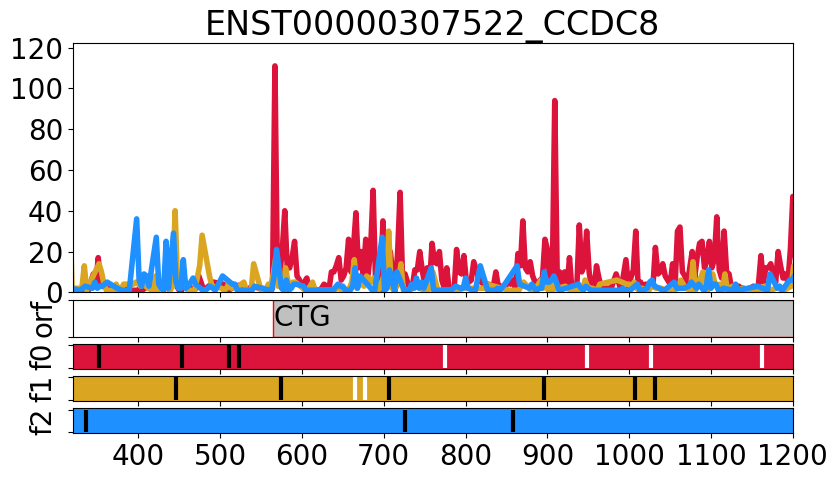

In [7]:
gene = 'CCDC8'

tr_id = 'ENST00000307522'

pre_st = '565_CTG'

xlims = [320, 1200]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq =100, 
                             cds = False,
                             name = 'CCDC8.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 'CCDC8.png', font1=20, font2=24)

18669
0


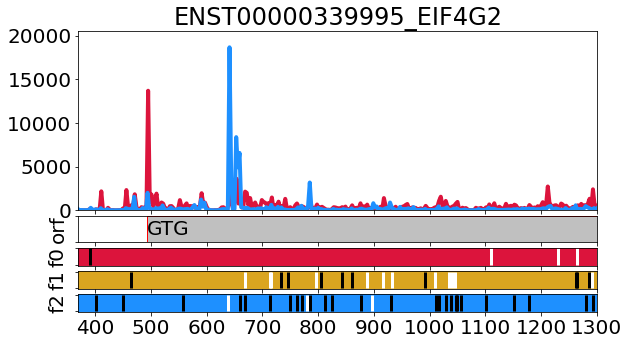

In [9]:
gene = 'EIF4G2'

tr_id = 'ENST00000339995'

pre_st = '493_GTG'

xlims = [370, 1300]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5000, 
                             fraq =100, 
                             cds = False,
                             name = 'EIF4G2.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,3]
                           )

trips_full_frames(d1, name = 'EIF4G2.png', font1=20, font2=24)

2046
0


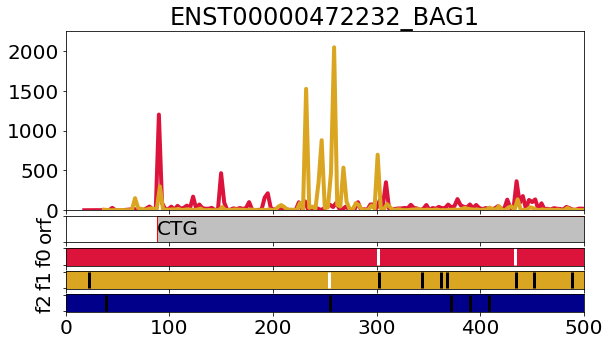

In [8]:
gene = 'BAG1'

tr_id = 'ENST00000472232'

pre_st = '88_CTG'

xlims = [0, 500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq =100, 
                             cds = False,
                             name = 'BAG1.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2]
                           )

trips_full_frames(d1, name = 'BAG1.png', font1=20, font2=24)

544
0


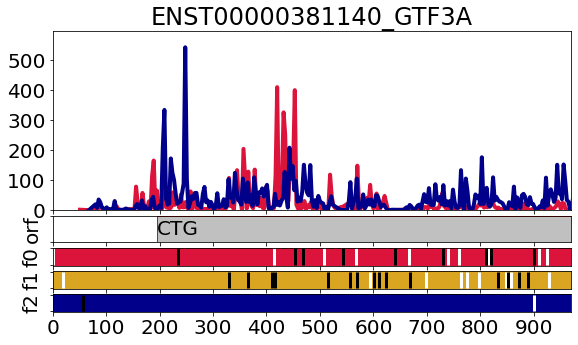

In [12]:
gene = 'GTF3A'

tr_id = 'ENST00000381140'

pre_st = '195_CTG'

xlims = [0, 970]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq =100, 
                             cds = False,
                             name = 'GTF3A.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,3]
                           )

trips_full_frames(d1, name = 'GTF3A.png', font1=20, font2=24)

3217
0


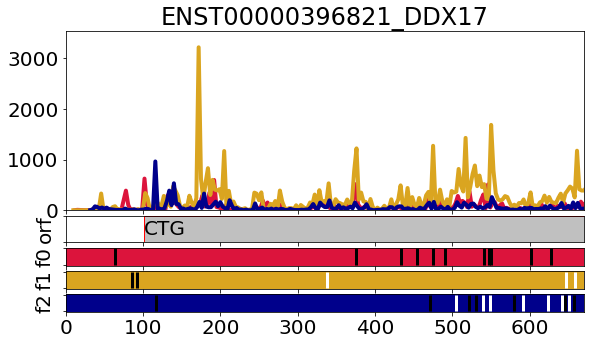

In [9]:
gene = 'DDX17'

tr_id = 'ENST00000396821'

pre_st = '101_CTG'

xlims = [0, 670]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq =100, 
                             cds = False,
                             name = 'DDX17.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3]
                           )

trips_full_frames(d1, name = 'DDX17.png', font1=20, font2=24)

1605
0


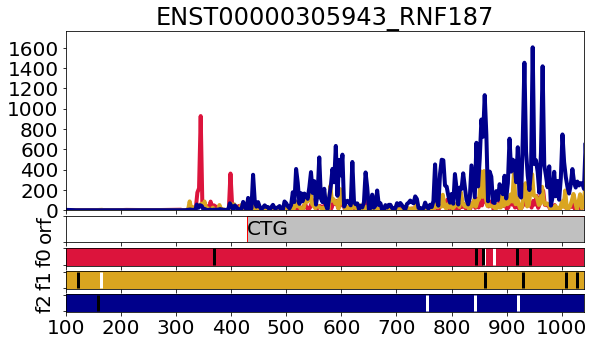

In [11]:
gene = 'RNF187'

tr_id = 'ENST00000305943'

pre_st = '429_CTG'

xlims = [100, 1040]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq =100, 
                             cds = False,
                             name = 'RNF187.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3]
                           )

trips_full_frames(d1, name = 'RNF187.png', font1=20, font2=24)

1171
0


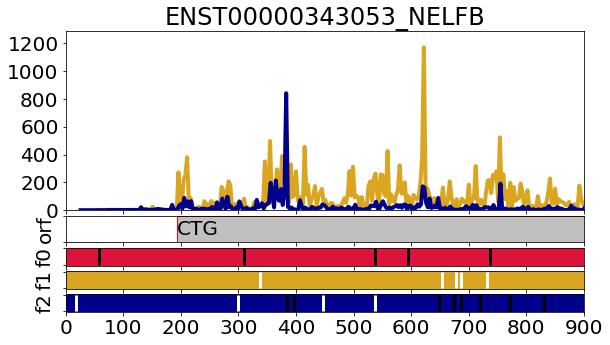

In [16]:
gene = 'NELFB'

tr_id = 'ENST00000343053'

pre_st = '194_CTG'

xlims = [0, 900]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq =100, 
                             cds = False,
                             name = 'NELFB.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[2,3]
                           )

trips_full_frames(d1, name = 'NELFB.png', font1=20, font2=24)

149
0


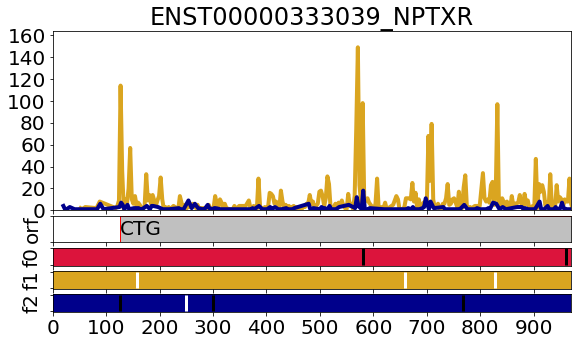

In [9]:
gene = 'NPTXR'

tr_id = 'ENST00000333039'

pre_st = '125_CTG'

xlims = [0, 970]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq =100, 
                             cds = False,
                             name = 'NPTXR.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[2,3]
                           )

trips_full_frames(d1, name = 'NPTXR.png', font1=20, font2=24)

1367
0


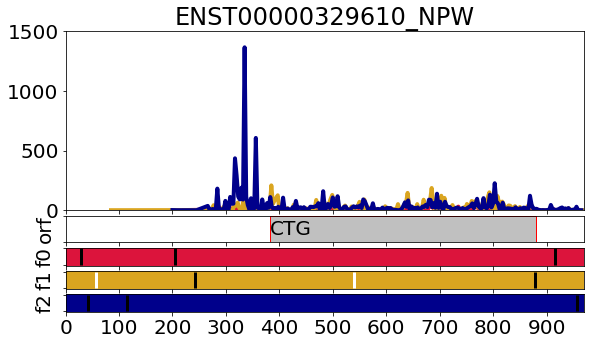

In [16]:
gene = 'NPW'

tr_id = 'ENST00000329610'

pre_st = '383_CTG'

xlims = [0, 970]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq =100, 
                             cds = False,
                             name = 'NPW.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3],
                            #ylim=250
                           )

trips_full_frames(d1, name = 'NPW.png', font1=20, font2=24)

555
0


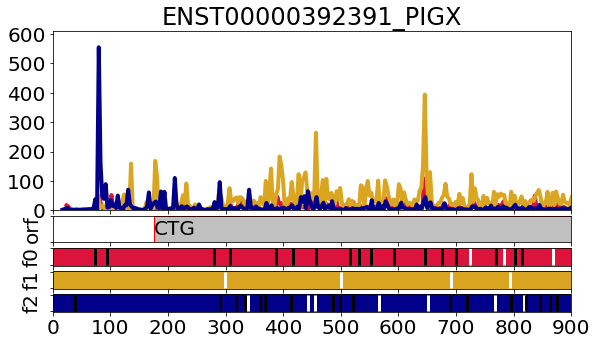

In [8]:
gene = 'PIGX'

tr_id = 'ENST00000392391'

pre_st = '176_CTG'

xlims = [0, 900]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq =100, 
                             cds = False,
                             name = 'PIGX.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3]
                           )

trips_full_frames(d1, name = 'PIGX.png', font1=20, font2=24)

1313
0


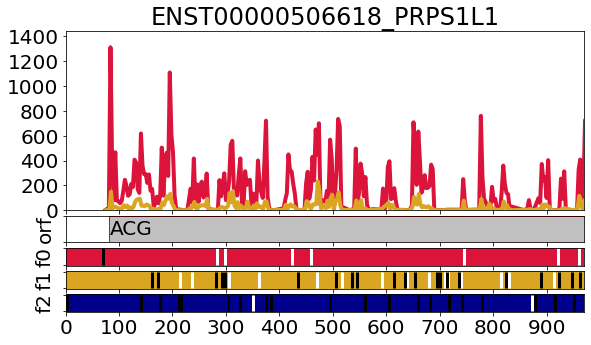

In [20]:
gene = 'PRPS1L1'

tr_id = 'ENST00000506618'

pre_st = '82_ACG'

xlims = [0, 970]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq =100, 
                             cds = False,
                             name = 'PRPS1L1.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2]
                           )

trips_full_frames(d1, name = 'PRPS1L1.png', font1=20, font2=24)

38
0


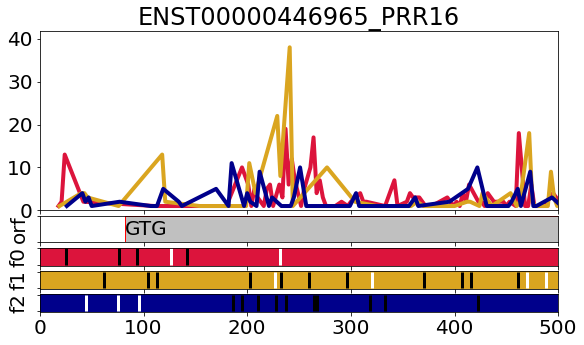

In [74]:
gene = 'PRR16'

tr_id = 'ENST00000446965'

pre_st = '82_GTG'

xlims = [0, 500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq =100, 
                             cds = False,
                             name = 'PRR16.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3]
                           )

trips_full_frames(d1, name = 'PRR16.png', font1=20, font2=24)

80
0


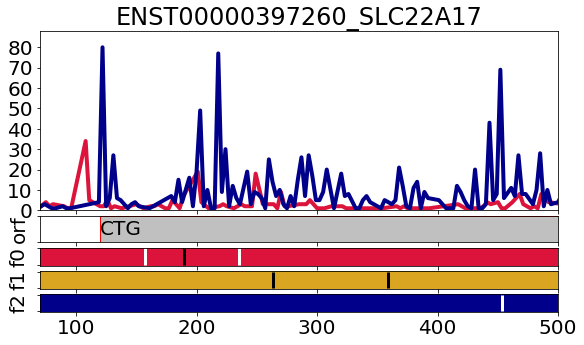

In [30]:
gene = 'SLC22A17'

tr_id = 'ENST00000397260'

pre_st = '120_CTG'

xlims = [70, 500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq =100, 
                             cds = False,
                             name = 'SLC22A17.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,3]
                           )

trips_full_frames(d1, name = 'SLC22A17.png', font1=20, font2=24)

392
0


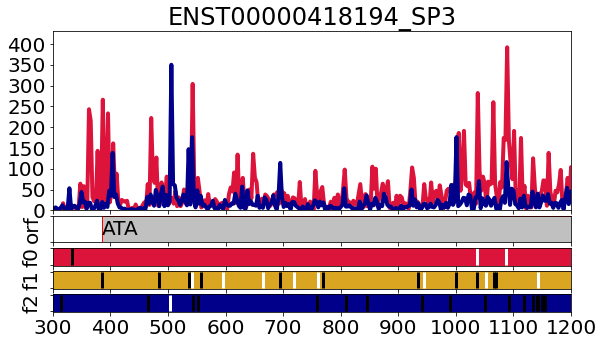

In [23]:
gene = 'SP3'

tr_id = 'ENST00000418194'

pre_st = '385_ATA'

xlims = [300, 1200]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq =100, 
                             cds = False,
                             name = 'SP3.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,3]
                           )

trips_full_frames(d1, name = 'SP3.png', font1=20, font2=24)

392
0


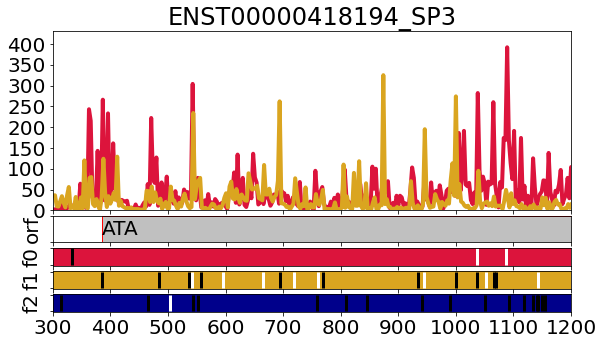

In [26]:
gene = 'SP3'

tr_id = 'ENST00000418194'

pre_st = '385_ATA'

xlims = [300, 1200]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq =100, 
                             cds = False,
                             name = 'SP3.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2]
                           )

trips_full_frames(d1, name = 'SP3.png', font1=20, font2=24)

4443
0


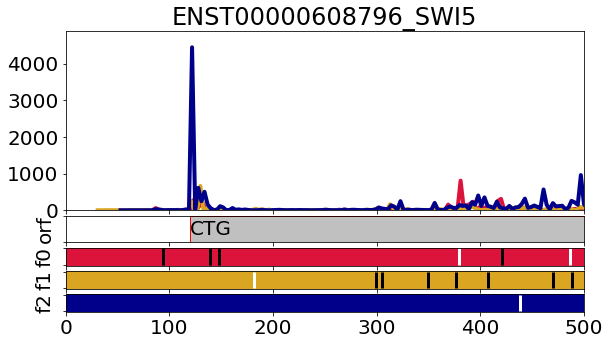

In [90]:
gene = 'SWI5'

tr_id = 'ENST00000608796'

pre_st = '120_CTG'

xlims = [0, 500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq =100, 
                             cds = False,
                             name = 'SWI5.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3]
                           )

trips_full_frames(d1, name = 'SWI5.png', font1=20, font2=24)

103
0


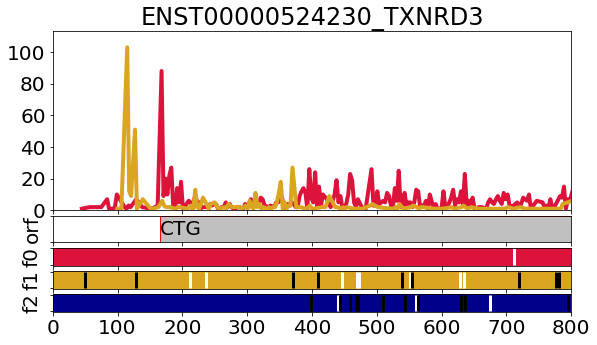

In [24]:
gene = 'TXNRD3'

tr_id = 'ENST00000524230'

pre_st = '166_CTG'

xlims = [0, 800]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq =100, 
                             cds = False,
                             name = 'TXNRD3.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2]
                           )

trips_full_frames(d1, name = 'TXNRD3.png', font1=20, font2=24)

573
0


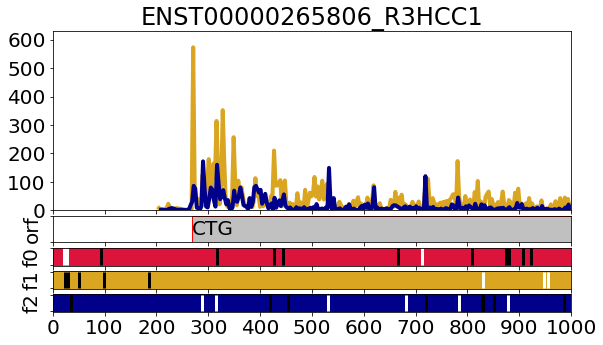

In [44]:
gene = 'R3HCC1'

tr_id = 'ENST00000265806'

pre_st = '269_CTG'

xlims = [0, 1000]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq =100, 
                             cds = False,
                             name = 'NPW.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[2,3]
                           )

trips_full_frames(d1, name = 'R3HCC1.png', font1=20, font2=24)

In [33]:
metadata_pc_g25[metadata_pc_g25['gene'] == 'R3HCC1'][['cds_start_codon', 'tr_id']]

,cds_start_codon,tr_id
36608,CTG,ENST00000517633.5
36609,CTG,ENST00000522012.5
36610,CTG,ENST00000625275.2
36611,CTG,ENST00000265806.10
36612,ATG,ENST00000411463.2
36613,CTG,ENST00000519952.5
36614,CTG,ENST00000518840.5
36615,CTG,ENST00000521588.3
36616,GAA,ENST00000520480.5
